In [1]:
import numpy as np
import pandas as pd

In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# nbody = client_e1abc.get_object(Bucket='ecommercebehaviourdeterminingbuye-donotdelete-pr-3tt2otgwfskab0',Key='2019-Nov.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df = pd.read_csv(body)

In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:02 UTC,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
1,2019-11-01 00:00:09 UTC,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
2,2019-11-01 00:00:10 UTC,view,5837166,1783999064103190764,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
3,2019-11-01 00:00:11 UTC,cart,5876812,1487580010100293687,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7
4,2019-11-01 00:00:24 UTC,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635837 entries, 0 to 4635836
Data columns (total 9 columns):
event_time       object
event_type       object
product_id       int64
category_id      int64
category_code    object
brand            object
price            float64
user_id          int64
user_session     object
dtypes: float64(1), int64(3), object(5)
memory usage: 318.3+ MB


## 1. Data Preprocessing

Nan Values

In [5]:
df.columns[df.isna().any()].tolist()

['category_code', 'brand', 'user_session']

In [6]:
df.dropna(subset=['user_session'], axis=0, inplace=True)

Format

In [7]:
df['event_time'] = pd.to_datetime(df['event_time'], format = '%Y-%m-%d %H:%M:%S UTC')

In [8]:
#format so each row must represent a single type of product that a user has placed in their cart, eliminating duplicates
df = df.loc[df['event_type'].isin(['remove_from_cart','purchase'])]
df = df.drop_duplicates(subset=['event_type', 'category_code', 'user_session', 'category_id', 'product_id'])

Feature Engineering

In [9]:
#get weekday from time
df = df.reset_index()
df['weekday'] = df['event_time'].dt.dayofweek

In [10]:
#get shopping hour from time
df['shopping_hour'] = df['event_time'].dt.hour

In [11]:
df.columns[df.isna().any()].tolist()

['category_code', 'brand']

In [12]:
#drop event_time
df.drop(columns=['event_time'], inplace=True)

In [13]:
#get feature for activity number in session
activity_count = df.groupby('user_session')['event_type'].count().reset_index()
activity_count = activity_count.rename(columns={"event_type": "activity_count"})
df = df.merge(activity_count)

In [14]:
#get cart price total for the session
sales_total = df.groupby('user_session')['price'].sum().reset_index()
sales_total = sales_total.rename(columns={"price": "sales_total_price"})
df = df.merge(sales_total)
df.head()

,index,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,weekday,shopping_hour,activity_count,sales_total_price
0,4,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,4,0,1,3.33
1,8,remove_from_cart,5870838,1487580007675986893,NaN,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,4,0,2,1.58
2,10,remove_from_cart,5870803,1487580007675986893,NaN,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,4,0,2,1.58
3,13,remove_from_cart,5710314,1487580005268456287,NaN,lianail,5.54,566239468,3ad69360-e328-454a-b1f8-0e0901e1e344,4,0,8,35.56
4,54,remove_from_cart,5851312,1487580005268456287,NaN,lianail,6.33,566239468,3ad69360-e328-454a-b1f8-0e0901e1e344,4,0,8,35.56


In [15]:
del activity_count, sales_total #free storage memory

In [16]:
#categorical vairables encoding
df['event_type'] = df['event_type'].replace('remove_from_cart', 0)
df['event_type'] = df['event_type'].replace('purchase', 1)

In [17]:
df = df[['user_id', 'user_session', 'event_type', 'category_code', 'brand', 'price', 'weekday', 'shopping_hour', 'activity_count', 'sales_total_price']]
df.head()

,user_id,user_session,event_type,category_code,brand,price,weekday,shopping_hour,activity_count,sales_total_price
0,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,0,NaN,NaN,3.33,4,0,1,3.33
1,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,0,NaN,milv,0.79,4,0,2,1.58
2,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,0,NaN,milv,0.79,4,0,2,1.58
3,566239468,3ad69360-e328-454a-b1f8-0e0901e1e344,0,NaN,lianail,5.54,4,0,8,35.56
4,566239468,3ad69360-e328-454a-b1f8-0e0901e1e344,0,NaN,lianail,6.33,4,0,8,35.56


In [18]:
#resample as processing memory is too large
count_class_0, count_class_1 = df['event_type'].value_counts()

df_class_0 = df[df['event_type'] == 0]
df_class_1 = df[df['event_type'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df = pd.concat([df_class_0_under, df_class_1], axis=0)

df = df.sample(frac=0.2, replace=False, random_state=1)

print('Random under-sampling:')
print(df['event_type'].value_counts())

Random under-sampling:
1    64317
0    63890
Name: event_type, dtype: int64


In [19]:
df.shape

(128207, 10)

In [27]:
print(df['category_code'].nunique()) #number of categories
print(df['brand'].nunique()) #number of brands

10
210


In [28]:
# generate binary values using get_dummies for category codes and brands
df = pd.get_dummies(df, columns=['category_code', 'brand'])
df.head()

,user_id,user_session,event_type,price,weekday,shopping_hour,activity_count,sales_total_price,category_code_accessories.bag,category_code_accessories.cosmetic_bag,...,brand_uno,brand_uskusi,brand_veraclara,brand_vilenta,brand_vosev,brand_yoko,brand_ypsed,brand_yu-r,brand_zeitun,brand_zinger
275314,534607837,335873b6-6df8-4145-95f1-9a56c68c032f,0,0.95,6,17,48,214.50,0,0,...,0,0,0,0,0,0,0,0,0,0
117613,477729759,6241fcae-cb31-4f33-b7a4-8abaaeb434d4,1,6.03,1,14,20,54.78,0,0,...,0,0,0,0,0,0,0,0,0,0
252870,569404467,bb60e80e-af0e-4304-8811-2d93c7d155ee,0,7.46,5,16,2,14.92,0,0,...,0,0,0,0,0,0,0,0,0,0
143869,334373423,63c8d003-8967-4bdc-83cb-bd0fca18b806,0,6.03,2,14,10,46.10,0,0,...,0,0,0,0,0,0,0,0,0,0
3063,565825656,51df8dc6-4b9e-4811-ad87-9cb84229ce0e,1,1.98,4,6,46,297.39,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df.shape

(128207, 228)

In [30]:
y = df.iloc[:,2]
X = df.iloc[:,3:228]

## 2. Model Developement

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (89744, 225) (89744,)
Test set: (38463, 225) (38463,)


### XGBoost

In [33]:
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.1)
model.fit(X_train, y_train)
yhat = model.predict(X_test)

from sklearn.metrics import accuracy_score
from sklearn import metrics
predictions = [round(value) for value in yhat]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall:",metrics.recall_score(y_test, yhat))

Accuracy: 60.82%
Recall: 0.7406405990016639


### Log Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)

#evaluation test
predictions = [round(value) for value in yhat]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall:",metrics.recall_score(y_test, yhat))

Accuracy: 53.63%
Recall: 0.6438747920133111


### K-Nearest Neighbour (KNN)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
mean_acc

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.7064451550841068 with k= 1


In [36]:
from matplotlib import pyplot as plt
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.show()

<Figure size 640x480 with 1 Axes>

In [37]:
k = 1
#Train Model and Predict
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)
predictions = [round(value) for value in yhat]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall:",metrics.recall_score(y_test, yhat))

Accuracy: 70.64%
Recall: 0.7184900166389351


## 3. Results and Conclusion

Text(0.5, 1.0, 'Model Accuracy')

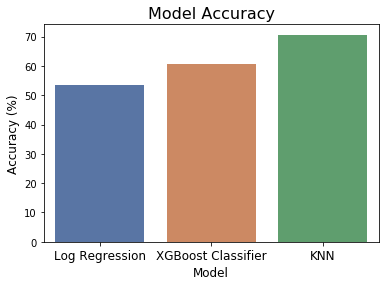

In [55]:
accuracy = [53.63, 60.82, 70.64]
model = ['Log Regression', 'XGBoost Classifier', 'KNN']
import seaborn as sns
sns.barplot(x=model, y=accuracy)
sns.set_palette('deep')
plt.ylabel('Accuracy (%)', size = 12)
plt.xlabel('Model', size = 12)
plt.xticks(size=12)
plt.title('Model Accuracy', size=16)